# Geometric Analytics for Functional Shape Descriptors

This notebook is part of the lab semiar [Current research topics in visual and data-centric computing](https://www.fu-berlin.de/vv/en/lv/873230?m=428943&pc=575084&sm=814672) at Freie Universität Berlin.

This week's assignment is on using the functional maps framework to obtain shape differences. These difference then allow us to investigate a collection of shapes using (gemetric) data analysis.

Outline:
* Functional Characterization of Shape Differences
* Statistical Shape Analysis


## Setup environment

Let's install the required python packages, in particular:
* [Morphomatics](https://morphomatics.github.io) for geometric statistics
* [robust-laplacian](https://github.com/nmwsharp/robust-laplacians-py) and SciPy for computing manifold harmonics
* [PyVista](https://docs.pyvista.org/) for visualization of surfaces and functions on it (requires openGL, hence, installation of `xvfb` and `mesa` system components)

In [1]:
import pyvista as pv

# Seems that only static plotting is supported on colab at the moment
pv.global_theme.jupyter_backend = 'static'
pv.global_theme.notebook = True
pv.start_xvfb()

## Reproduce code from last week's session that will be needed again

In [2]:
# manifold harmonics
from robust_laplacian import mesh_laplacian
import numpy as np
from scipy import sparse

def mfd_harmonics(surf: pv.PolyData, n: int):
  # setup generalized eigensystem
  v = np.asarray(surf.points)
  f = np.asarray(surf.faces.reshape(-1, 4)[:, 1:])
  S, M = mesh_laplacian(v, f)
  # solve generalized eigenvalue problem S * v = lambda * M * v
  # (M is diagonal, thus, speed up using change of variables u = M^.5 * v)
  sqrtMinv = sparse.diags(1 / np.sqrt(M.data))
  evals, evecs = sparse.linalg.eigsh(sqrtMinv @ S @ sqrtMinv, n, sigma=-1e-8)
  return evals, sqrtMinv @ evecs, M

# convert functional map to point-to-point map
from sklearn.neighbors import NearestNeighbors

def compute_pt2pt(Phi_S: np.ndarray, Phi_T: np.ndarray, C):
  n_S, n_T = len(Phi_S), len(Phi_T)
  k_T, k_S = C.shape
  nn = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(Phi_S[:, :k_S] @ C.T)
  idx = nn.kneighbors(Phi_T[:, :k_T], return_distance=False).squeeze()
  return sparse.csr_matrix((np.ones(n_T), (np.arange(n_T), idx)), shape=(n_T, n_S))

In [3]:
# load meshes and compute harmonics
S = pv.read('FAUST_r/off_2/tr_reg_000.off').extract_surface()
lambda_S, phi_S, M_S = mfd_harmonics(S, 30)
T = pv.read('FAUST_r/off_2/tr_reg_099.off').extract_surface()
lambda_T, phi_T, M_T = mfd_harmonics(T, 30)

# init 4x4 functional map
C = np.eye(4)
C[2,2] = -1
C[3,3] = -1
# TODO: set entries by hand

In [4]:
# ZoomOut
from typing import NamedTuple, Sequence

class Shape(NamedTuple):
  mesh: pv.PolyData
  Lambda: np.ndarray
  Phi: np.ndarray
  M: sparse.spmatrix

def zoomout(S: Shape, T: Shape, num_step: int = 10, step: Sequence[int] = (1,2)):
  # # init 4x4 functional map assuming aligned shapes ...
  C = np.eye(4)
  C[0,0] = T.Phi[0,0] / S.Phi[0,0]
  # proj = lambda O: O.Phi[:, 1:4].T @ O.M @ (O.mesh.points / O.mesh.points.max(axis=0))
  # # ... using least-square solve
  # # C[1:,1:] = np.linalg.lstsq(proj(S).T, proj(T).T)[0].T
  # # ... solving Procrustes problem
  # U, _, Vt = np.linalg.svd(proj(T) @ proj(S).T)
  # C[1:,1:] = U @ Vt
  #... 'by hand' using knowledge of consistent alignment
  diff = lambda O, i, j: O.mesh.points[O.Phi[:,i].argmax(),j] - O.mesh.points[O.Phi[:,i].argmin(),j]
  C[1,1] = np.sign(diff(S,1,1)) * np.sign(diff(T,1,1))
  C[2,2] = np.sign(diff(S,2,0)) * np.sign(diff(T,2,0))
  C[3,3] = np.sign(diff(S,3,0)) * np.sign(diff(T,3,0))

  # spectral upsampling
  for k_S, k_T in np.outer(np.arange(num_step)+1, step)+C.shape:
    # convert to pt-2-pt map
    P = compute_pt2pt(S.Phi, T.Phi, C)
    # convert to functional map
    C = T.Phi.T[:k_T] @ T.M @ P @ S.Phi[:, :k_S]
    # orthogonal regularization
    # if C.shape[0]==C.shape[1]:
    #   U, _, Vt = np.linalg.svd(C)
    #   C = U @ Vt

  return C

## Functional Characterization of Shape Differences

The functional map framework allows us to compare shapes by comparing inner products of the corresponding function spaces, see the semial work by Rustamov et al. (2013).

> Rustamov, R. M., Ovsjanikov, M., Azencot, O., Ben-Chen, M., Chazal, F., & Guibas, L.:</br>
> **[Map-based exploration of intrinsic shape differences and variability.](https://www.lix.polytechnique.fr/~maks/papers/map_exploration.pdf)**  
> ACM Transactions on Graphics, 32(4), 1-12, 2013.</br>
> [![DOI](https://img.shields.io/badge/DOI-10.1145/2461912.2461959-yellow)](https://doi.org/10.1145/2461912.2461959)

> <img src="https://cdn-icons-png.freepik.com/256/8089/8089604.png?semt=ais_hybrid" alt="drawing" width="100"/> <br>
> * Compute the area-based shape difference for a pair of FAUST shapes
> * Investigate the spectrum of the difference
> * Visualize the most dominant eigenfunction
> * Optional: do the above steps also for the conformal-based shape difference
> * Remark: you can find the formular in Eq. (3) in [Rustamov et al. 2013], where
>   - for the area-based inner product, $H^N$ and $H^M$ are identity matrices as the manifold harmonics are $M$-orthogonal,
>   - $F$ instead of $C$ is used to denote a functional map

Shape2 Phi.T shape: (50, 5000)
Shape2 M shape: (5000, 5000)
Shape2 Phi shape: (5000, 50)
C shape: (50, 50)
Shape1 Phi.T shape: (50, 4999)
Shape1 M shape: (4999, 4999)
Shape1 Phi shape: (4999, 50)


/tmp/ipykernel_6827/475957261.py:89: RuntimeWarning: divide by zero encountered in divide
  pseudo_inv_Lambda1 = sparse.diags(1 / pseudo_inv_Lambda1)


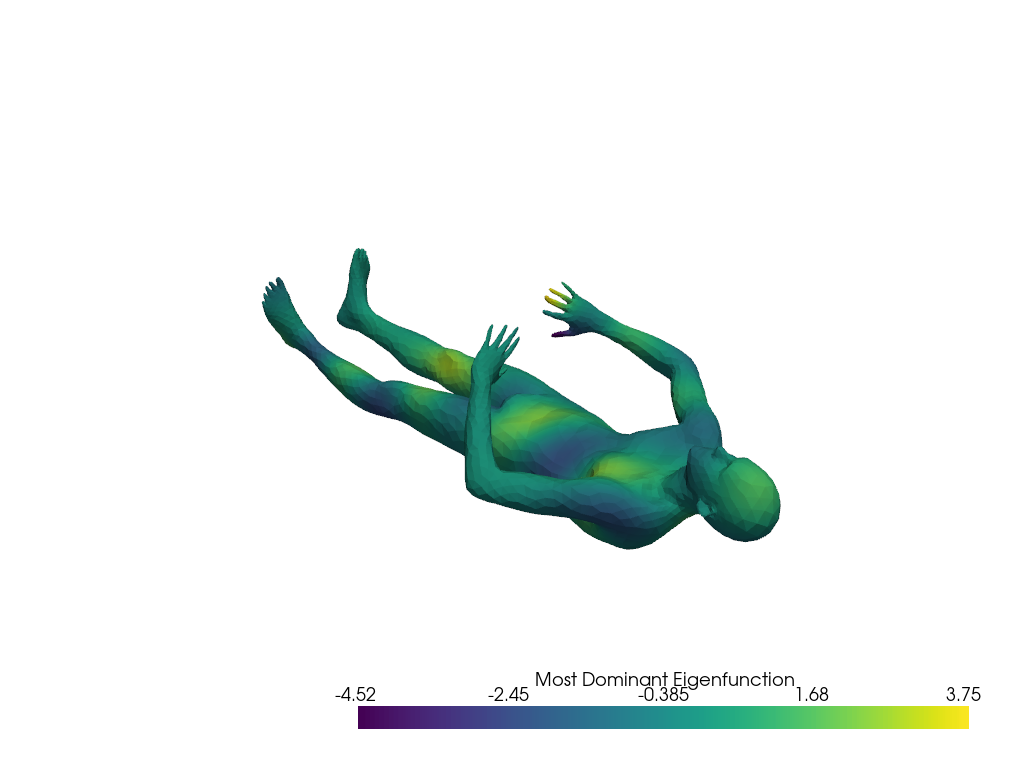

Plot saved as sjn/Desktop/dominant_eigenfunction_plot.png


In [5]:
import os
import trimesh
import numpy as np
import pyvista as pv
from tqdm import tqdm
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import jax
from morphomatics.manifold import SPD
from morphomatics.stats import PrincipalGeodesicAnalysis as PGA

# Function to load .off files using trimesh and convert to pyvista
def load_off_shape(idx, dataset_dir='FAUST_r/off_2'):
    filename = os.path.join(dataset_dir, f'tr_reg_{idx:03d}.off')
    if not os.path.isfile(filename):
        raise FileNotFoundError(f'File ({filename}) not found')
    mesh = trimesh.load_mesh(filename)
    return pv.wrap(mesh)

def mfd_harmonics(surf: pv.PolyData, n: int):
    v = np.asarray(surf.points)
    f = np.asarray(surf.faces.reshape(-1, 4)[:, 1:])
    S, M = mesh_laplacian(v, f)
    sqrtMinv = sparse.diags(1 / np.sqrt(M.data))
    evals, evecs = sparse.linalg.eigsh(sqrtMinv @ S @ sqrtMinv, n, sigma=-1e-8)
    return evals, sqrtMinv @ evecs, M

def compute_pt2pt(Phi_S: np.ndarray, Phi_T: np.ndarray, C):
    n_S, n_T = len(Phi_S), len(Phi_T)
    k_T, k_S = C.shape
    nn = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(Phi_S[:, :k_S] @ C.T)
    idx = nn.kneighbors(Phi_T[:, :k_T], return_distance=False).squeeze()
    return sparse.csr_matrix((np.ones(n_T), (np.arange(n_T), idx)), shape=(n_T, n_S))

class Shape(NamedTuple):
    mesh: pv.PolyData
    Lambda: np.ndarray
    Phi: np.ndarray
    M: sparse.spmatrix

def zoomout(S: Shape, T: Shape, num_step: int = 10, step: Sequence[int] = (1,2)):
    C = np.eye(min(S.Phi.shape[1], T.Phi.shape[1]))  # Ensure initial C is square and compatible
    C[0,0] = T.Phi[0,0] / S.Phi[0,0]
    diff = lambda O, i, j: O.mesh.points[O.Phi[:,i].argmax(),j] - O.mesh.points[O.Phi[:,i].argmin(),j]
    C[1,1] = np.sign(diff(S,1,1)) * np.sign(diff(T,1,1))
    C[2,2] = np.sign(diff(S,2,0)) * np.sign(diff(T,2,0))
    C[3,3] = np.sign(diff(S,3,0)) * np.sign(diff(T,3,0))

    for k_S, k_T in np.outer(np.arange(num_step)+1, step)+C.shape:
        P = compute_pt2pt(S.Phi, T.Phi, C)
        k_S, k_T = min(k_S, S.Phi.shape[1]), min(k_T, T.Phi.shape[1])  # Adjust harmonics count
        C = T.Phi.T[:k_T] @ T.M @ P @ S.Phi[:, :k_S]
        if C.shape[0]==C.shape[1]:
            U, _, Vt = np.linalg.svd(C)
            C = U @ Vt

    return C

# Load two shapes
shape1 = load_off_shape(0, dataset_dir='FAUST_r/off_2')
shape2 = load_off_shape(1, dataset_dir='FAUST_r/off_2')

# Compute the manifold harmonics for both shapes
evals1, evecs1, M1 = mfd_harmonics(shape1, n=50)
evals2, evecs2, M2 = mfd_harmonics(shape2, n=50)

shape1_data = Shape(mesh=shape1, Lambda=evals1, Phi=evecs1, M=M1)
shape2_data = Shape(mesh=shape2, Lambda=evals2, Phi=evecs2, M=M2)

# Compute the functional map
C = zoomout(shape1_data, shape2_data)

# Debug prints to check matrix dimensions
print("Shape2 Phi.T shape:", shape2_data.Phi.T.shape)
print("Shape2 M shape:", shape2_data.M.shape)
print("Shape2 Phi shape:", shape2_data.Phi.shape)
print("C shape:", C.shape)
print("Shape1 Phi.T shape:", shape1_data.Phi.T.shape)
print("Shape1 M shape:", shape1_data.M.shape)
print("Shape1 Phi shape:", shape1_data.Phi.shape)

# Adjust functional map dimensions if necessary
C = C[:shape2_data.Phi.shape[1], :shape1_data.Phi.shape[1]]

# Compute the pseudo-inverse of Lambda
pseudo_inv_Lambda1 = np.copy(shape1_data.Lambda)
pseudo_inv_Lambda1[0] = 0  # Set the first entry to zero
pseudo_inv_Lambda1 = sparse.diags(1 / pseudo_inv_Lambda1)

# Area-based shape difference using the provided formula D = (H_M)^{-1} C^T H_N C
H_M_inv = pseudo_inv_Lambda1  # Pseudo-inverse of H_M
H_N = sparse.diags(shape2_data.Lambda)          # H_N
area_diff = H_M_inv @ (C.T @ H_N @ C)

# Spectrum of the difference
evals_diff, evecs_diff = np.linalg.eigh(area_diff)

# Interpolate the eigenfunction to match the original points of shape2
dominant_eigenfunction = shape2_data.Phi @ evecs_diff[:, -1]
dominant_eigenfunction_full = np.zeros(shape2.n_points)
dominant_eigenfunction_full[:dominant_eigenfunction.shape[0]] = dominant_eigenfunction

# Visualize the most dominant eigenfunction by interpolating back to the original point space
plotter = pv.Plotter()
plotter.add_mesh(shape2, scalars=dominant_eigenfunction_full, scalar_bar_args={"title": "Most Dominant Eigenfunction"})

# Save the plot as an image file
screenshot_path = "sjn/Desktop/dominant_eigenfunction_plot.png"
os.makedirs(os.path.dirname(screenshot_path), exist_ok=True)  # Create the directory if it doesn't exist
plotter.screenshot(screenshot_path)
plotter.show()

print(f"Plot saved as {screenshot_path}")


## Geometric Statistics

Given a shape collection, a cannonical task is to study the variability therein. In the context of map-based shape differences, the data points are geometric objects that live in the space of symmetric, positive-definite (SPD) matrices. This is a curved manifold for which classical multivariate tools cannot be applied. Here we will use a generalization of principal component analysis (PCA) known as principal geodesic analysis (PGA) proposed in Fletcher et al. (2004).

> Fletcher, P. T., Lu, C., Pizer, S. M., & Joshi, S.:</br>
> **[Principal geodesic analysis for the study of nonlinear statistics of shape](https://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Fletcher04.pdf)**  
> IEEE transactions on medical imaging, 23(8), 995-1005, 2004.</br>
> [![DOI](https://img.shields.io/badge/DOI-10.1109/TMI.2004.831793-yellow)](https://doi.org/10.1109/TMI.2004.831793)

> <img src="https://cdn-icons-png.freepik.com/256/8089/8089604.png?semt=ais_hybrid" alt="drawing" width="100"/> <br>
> * Perform PGA for the FAUST dataset (at least for area-based differeneces)
> * Create a scatter plot based on PGA coefficients
>   - use different colors and glyphs for subjects and poses, respectively
> * Compare results to those obtained with standard PCA
> * Optional: How do the results depend on the choice of reference shape?

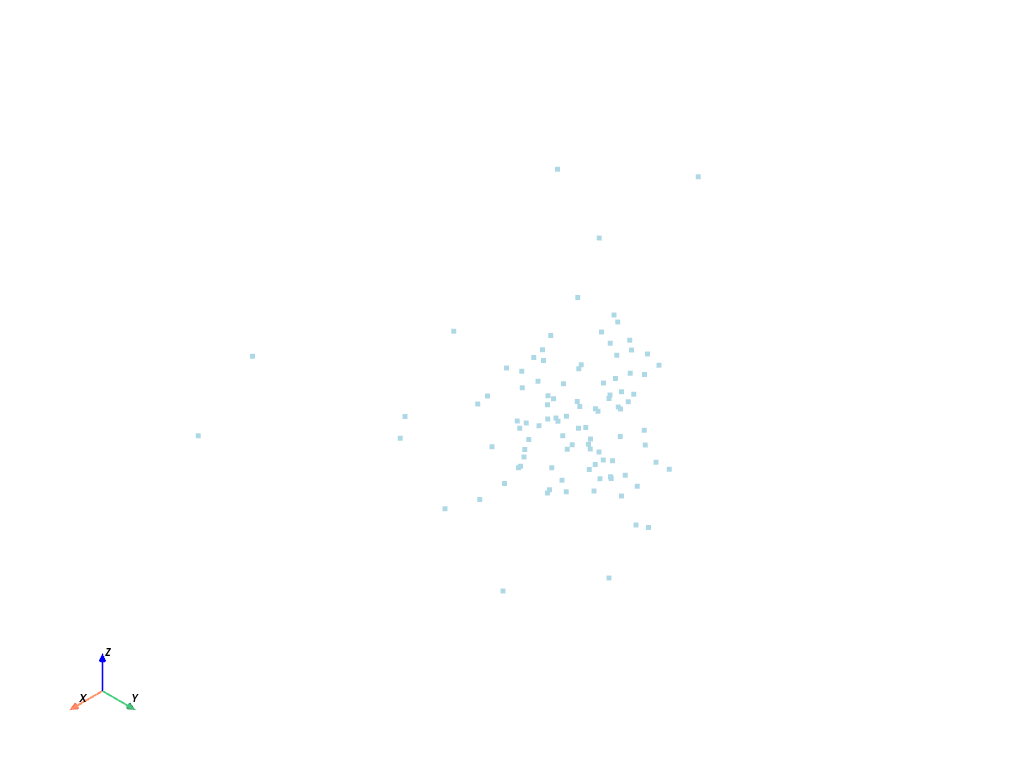

In [6]:
# We can use the Morphomatics library to compute PGA

import jax
from morphomatics.manifold import SPD
from morphomatics.stats import PrincipalGeodesicAnalysis as PGA

# create manifold of 5x5 SPD matrices
mfd = SPD(d=5, structure='AffineInvariant')

# random data
data = jax.vmap(mfd.rand)(jax.random.split(jax.random.key(42), 100))

# compute PGA
pga = PGA(mfd, data)

# 3D scatter plot
pv.PolyData(np.asarray(pga.coeffs[:, :3])).plot()

Shape of data array: (1, 50, 50)
[[[            nan             nan             nan ...             nan
               nan             nan]
  [            nan  5.83864669e+02 -1.75030144e+02 ...  5.46656043e-01
    1.57290361e+00  6.17144814e+00]
  [            nan -1.75030144e+02  2.70075038e+03 ...  1.22749186e-01
    2.88279263e+00  2.03053788e+00]
  ...
  [            nan  5.46656043e-01  1.22749186e-01 ...  5.50562491e-01
   -7.61288174e-02 -4.02196433e-02]
  [            nan  1.57290361e+00  2.88279263e+00 ... -7.61288174e-02
    6.74814249e-01 -5.20691960e-02]
  [            nan  6.17144814e+00  2.03053788e+00 ... -4.02196433e-02
   -5.20691960e-02  5.21770683e-01]]]
Error during PGA computation: index -2 is out of bounds for axis 0 with size 1


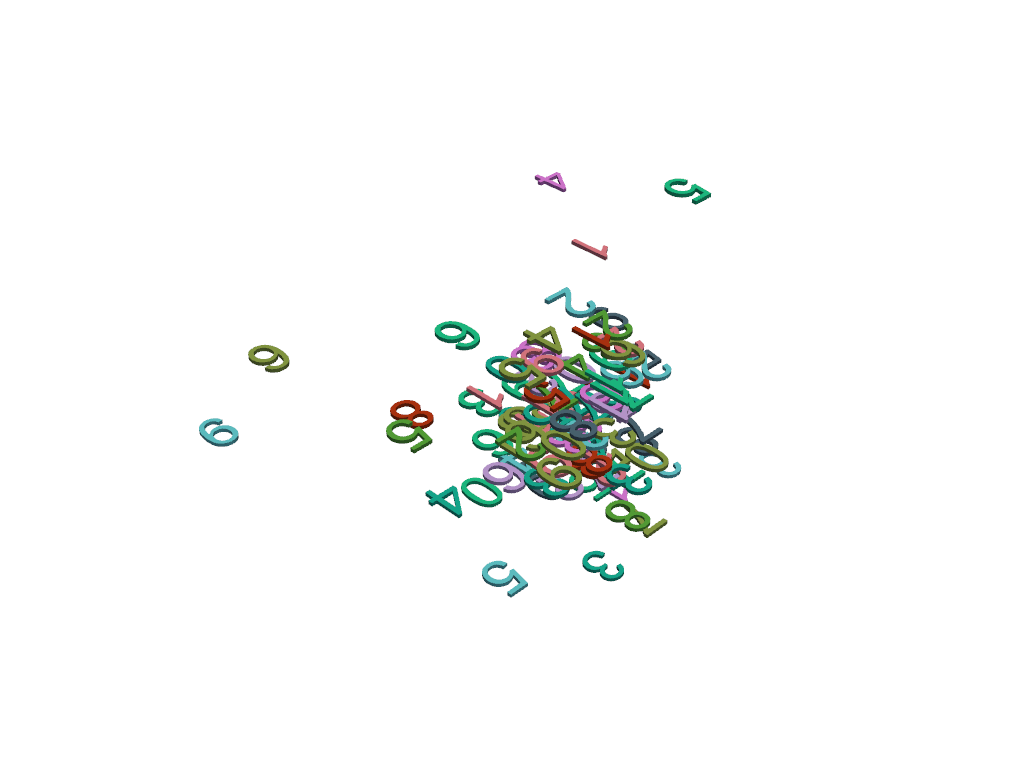

PGA scatter plot saved as sjn/Desktop/Project-2024/pga_scatter_plot.png


In [39]:
import os
import numpy as np
import pyvista as pv
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from morphomatics.manifold import SPD
from morphomatics.stats import PrincipalGeodesicAnalysis as PGA

# Assuming area_diffs is already computed and available
# Ensure it is in the right format
area_diffs = [area_diff]

# Check if there are any area differences computed
if not area_diffs:
    raise ValueError("No area differences computed. Ensure the shapes are correctly loaded and processed.")

# Convert area differences to SPD matrices (ensure they are sparse matrices)
spd_matrices = [sparse.csr_matrix(diff @ diff.T) for diff in area_diffs]

# Create manifold of SPD matrices
mfd = SPD(d=spd_matrices[0].shape[0], structure='AffineInvariant')

# Convert SPD matrices to dense arrays for JAX compatibility
data = np.array([matrix.A for matrix in spd_matrices])

# Check the shape of the data array
print("Shape of data array:", data.shape)

print(data)

# Compute PGA
try:
    pga = PGA(mfd, data)
except Exception as e:
    print("Error during PGA computation:", e)

# Scatter plot for PGA coefficients
try:
    coeffs = np.asarray(pga.coeffs[:, :3])
    
    # Create a 3D scatter plot with PyVista
    plotter = pv.Plotter()

    # Placeholder for subjects and poses
    # Update these arrays based on your specific dataset
    subjects = np.random.randint(0, 10, len(coeffs))  # Replace with actual subject data
    poses = np.random.randint(0, 10, len(coeffs))     # Replace with actual pose data

    # Define color lookup table
    unique_subjects = np.unique(subjects)
    subject_colors = {subject: np.random.random(3) for subject in unique_subjects}

    for i, point in enumerate(coeffs):
        color = subject_colors[subjects[i]]
        glyph_text = str(poses[i] % 10)  # Use numbers 0 to 9 as glyphs
        glyph = pv.Text3D(glyph_text, depth=0.1)
        glyph.points += point  # Move glyph to the correct position
        plotter.add_mesh(glyph, color=color)

    # Save the scatter plot as an image
    screenshot_path = "sjn/Desktop/Project-2024/pga_scatter_plot.png"
    os.makedirs(os.path.dirname(screenshot_path), exist_ok=True)  # Create the directory if it doesn't exist
    plotter.screenshot(screenshot_path)
    plotter.show()

    print(f"PGA scatter plot saved as {screenshot_path}")

except Exception as e:
    print("Error during scatter plot creation:", e)



(50, 50)
(50, 50)
PCA components shape: (50, 2)


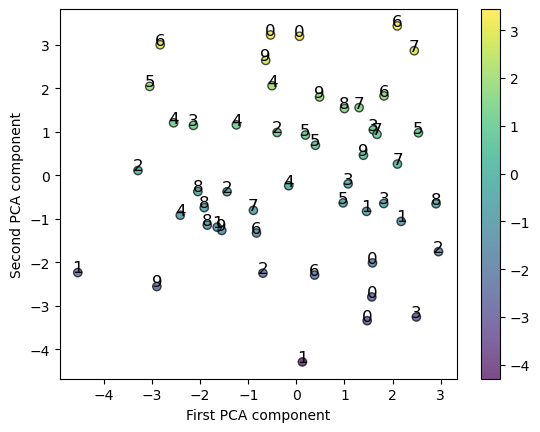

In [58]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print()

# Assuming area_diff is already computed and available
# Ensure it is in the right format
area_diff = np.array(area_diff)  # Convert to numpy array if not already
print(area_diff.shape)

# Reshape area_diff if necessary
data_pca = area_diff.reshape(len(area_diff), -1)


print(data_pca.shape)
#print(data_pca.dtype)
data_pca = pd.DataFrame(data_pca)



# Replace inf with NaN
data_pca.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
data_pca.dropna(inplace=True)

# Check for NaN or Infinity
if np.any(np.isnan(data_pca)):
    raise ValueError("Data contains NaNs or Infinities.")

if np.any(np.isinf(data_pca)):
    raise ValueError("Data contains Infinities.")


# Optional: Apply StandardScaler to scale the data for PCA
scaler = StandardScaler()
scaled_data_pca = scaler.fit_transform(data_pca)

# Compute PCA
pca = PCA(n_components=2)  # Adjust n_components as needed
pca.fit(scaled_data_pca)

# Transform data using PCA
pca_components = pca.transform(scaled_data_pca)

# Display results or use pca_components as needed
print("PCA components shape:", pca_components.shape)
#print(pca_components)

fig, ax = plt.subplots()

#cax = ax.scatter(pca_components[:, 0], pca_components[:, 1], c=pca_components[:, 1], cmap='viridis', edgecolor='k', alpha=0.7, marker='^')


cax = ax.scatter(pca_components[:, 0], pca_components[:, 1], c=pca_components[:, 1], cmap='viridis', edgecolor='k', alpha=0.7)


cbar = fig.colorbar(cax)

# Add numbers to each point
for i in range(len(pca_components)):
    ax.annotate(i % 10, (pca_components[i, 0], pca_components[i, 1]), fontsize=12, ha='center')


plt.xlabel("First PCA component")
plt.ylabel("Second PCA component")

plt.savefig("PCA.png")

#plt.show()
